In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install dask.dataframe
!pip install "dask[dataframe]"

In [ ]:
!git clone https://<classic token>@github.com/big-data-lab-umbc/multivariate-weather-data-clustering.git

In [4]:
%cd multivariate-weather-data-clustering

/content/multivariate-weather-data-clustering


In [ ]:
!python setup.py install

In [13]:
import xarray as xr
from mwdc.clustering.st_agglomerative import st_agglomerative

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path2 = ('/content/multivariate-weather-data-clustering/data/ERA5_meteo_sfc_2021_daily.nc')
data = xr.open_dataset(path2, decode_times=False) 
data

In [10]:
var = list(data.variables)[3:]


[2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 2 2 2 2 2 2 2 2 2 2 2]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,8.46,21.25,28.84,32.56,29.71,25.31,37.74
1,21.25,0.0,39.25,40.14,34.27,34.27,36.85
2,28.84,39.25,22.09,40.76,33.2,33.84,42.63
3,32.56,40.14,40.76,0.0,36.93,34.24,32.95
4,29.71,34.27,33.2,36.93,0.0,32.54,36.21
5,25.31,34.27,33.84,34.24,32.54,0.0,36.0
6,37.74,36.85,42.63,32.95,36.21,36.0,0.0



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.92,0.669591,0.096881,0.053266,0.064739,0.490378,-0.072925
1,0.669591,1.0,-0.154363,-0.22006,0.141229,0.240193,0.167486
2,0.096881,-0.154363,0.44,0.344216,-0.294478,0.474557,0.278604
3,0.053266,-0.22006,0.344216,1.0,-0.060491,0.163409,0.091396
4,0.064739,0.141229,-0.294478,-0.060491,1.0,0.220289,0.178738
5,0.490378,0.240193,0.474557,0.163409,0.220289,1.0,0.21354
6,-0.072925,0.167486,0.278604,0.091396,0.178738,0.21354,1.0




For n_clusters = 7 The average silhouette score is : 0.11694322254690184


For n_clusters = 7 The average davies bouldin score is : 0.6997941127400357


For n_clusters = 7 The average calinski harabasz score is : 3.022073580435005


2    358
0      2
3      1
6      1
5      1
4      1
1      1
Name: Cluster, dtype: int64


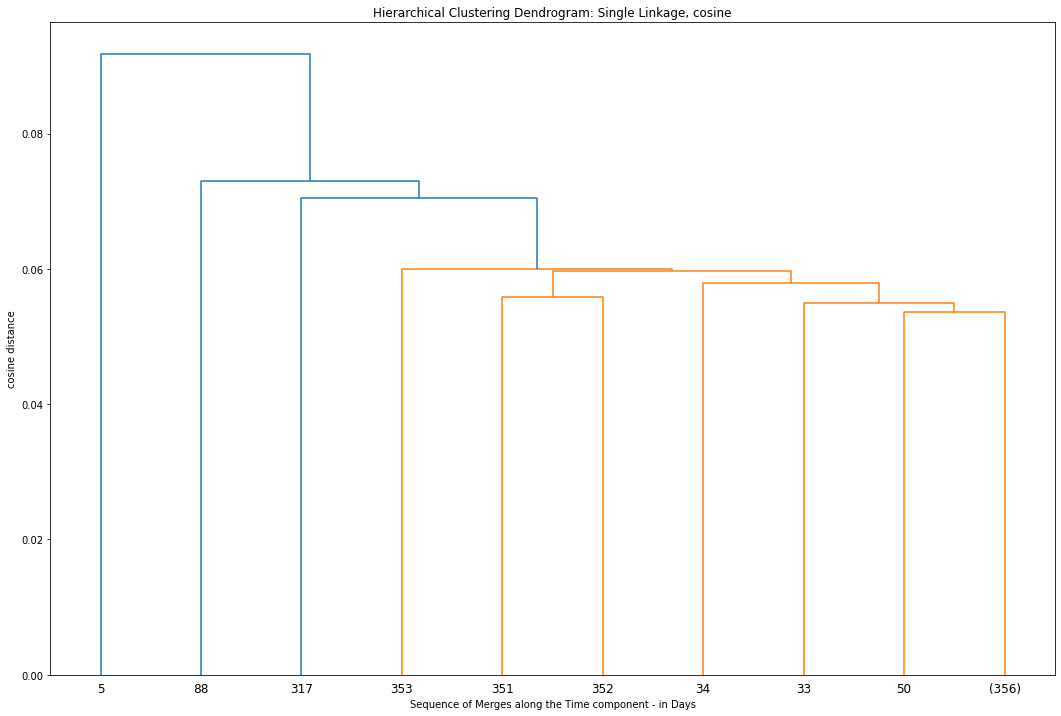

[2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 3 2 2
 2 2 2 2 2 2 2 1 1 2 2 2 1 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 4 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 2 2 4 4 4 4 2 1 1 2 2 2 2 2 4 4 4]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,16.49,40.76,27.77,48.77,35.7,46.77,42.68
1,40.76,14.69,28.74,26.34,21.84,34.86,27.45
2,27.77,28.74,16.14,41.03,26.05,39.11,28.45
3,48.77,26.34,41.03,0.0,39.81,32.95,36.0
4,35.7,21.84,26.05,39.81,14.87,35.92,25.35
5,46.77,34.86,39.11,32.95,35.92,0.0,34.24
6,42.68,27.45,28.45,36.0,25.35,34.24,0.0



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.6,-0.454222,-0.12375,-0.018327,-0.551848,0.083516,-0.199173
1,-0.454222,0.87,0.476545,0.596824,0.573488,0.023655,0.453899
2,-0.12375,0.476545,0.84,0.288135,0.397024,0.341332,0.629945
3,-0.018327,0.596824,0.288135,1.0,-0.079671,0.091396,0.21354
4,-0.551848,0.573488,0.397024,-0.079671,0.83,-0.028029,0.532319
5,0.083516,0.023655,0.341332,0.091396,-0.028029,1.0,0.163409
6,-0.199173,0.453899,0.629945,0.21354,0.532319,0.163409,1.0




For n_clusters = 7 The average silhouette score is : 0.28515353590898934


For n_clusters = 7 The average davies bouldin score is : 0.9179016763907988


For n_clusters = 7 The average calinski harabasz score is : 55.05637248877437


0    199
2    143
1     12
4      8
5      1
3      1
6      1
Name: Cluster, dtype: int64


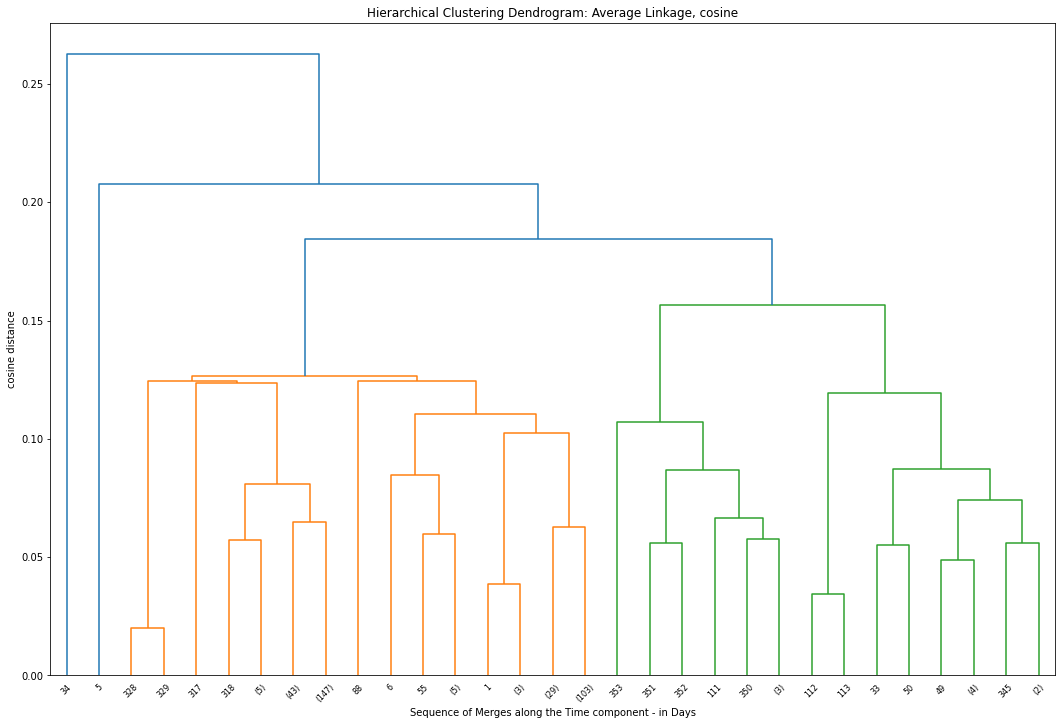

[3 6 6 6 6 6 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 4 1 3
 3 3 3 3 3 3 3 5 5 3 3 3 5 5 3 3 5 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 6 6 6 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3
 2 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 3 5 1 1 3 3 2 2 2 2 3 5 5 3 3 3 3 3 2 2 2]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,14.86,21.09,37.15,32.75,44.05,44.54,38.39
1,21.09,14.5,32.88,17.71,32.44,34.44,29.55
2,37.15,32.88,14.87,25.77,29.1,22.57,27.16
3,32.75,17.71,25.77,15.15,32.16,29.36,21.41
4,44.05,32.44,29.1,32.16,12.64,20.5,37.77
5,44.54,34.44,22.57,29.36,20.5,13.34,35.54
6,38.39,29.55,27.16,21.41,37.77,35.54,13.49



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.68,0.091137,-0.484071,-0.395087,-0.252222,-0.602367,-0.190881
1,0.091137,0.81,-0.217473,0.674984,0.490776,0.164553,0.333046
2,-0.484071,-0.217473,0.83,0.443715,0.269624,0.571108,0.325774
3,-0.395087,0.674984,0.443715,0.86,0.436353,0.490789,0.722474
4,-0.252222,0.490776,0.269624,0.436353,0.91,0.676326,-0.097376
5,-0.602367,0.164553,0.571108,0.490789,0.676326,0.91,0.038581
6,-0.190881,0.333046,0.325774,0.722474,-0.097376,0.038581,0.91




For n_clusters = 7 The average silhouette score is : 0.22061592563214152


For n_clusters = 7 The average davies bouldin score is : 1.345649368019902


For n_clusters = 7 The average calinski harabasz score is : 78.16642471649676


0    153
3    112
1     71
5     10
6      8
2      8
4      3
Name: Cluster, dtype: int64


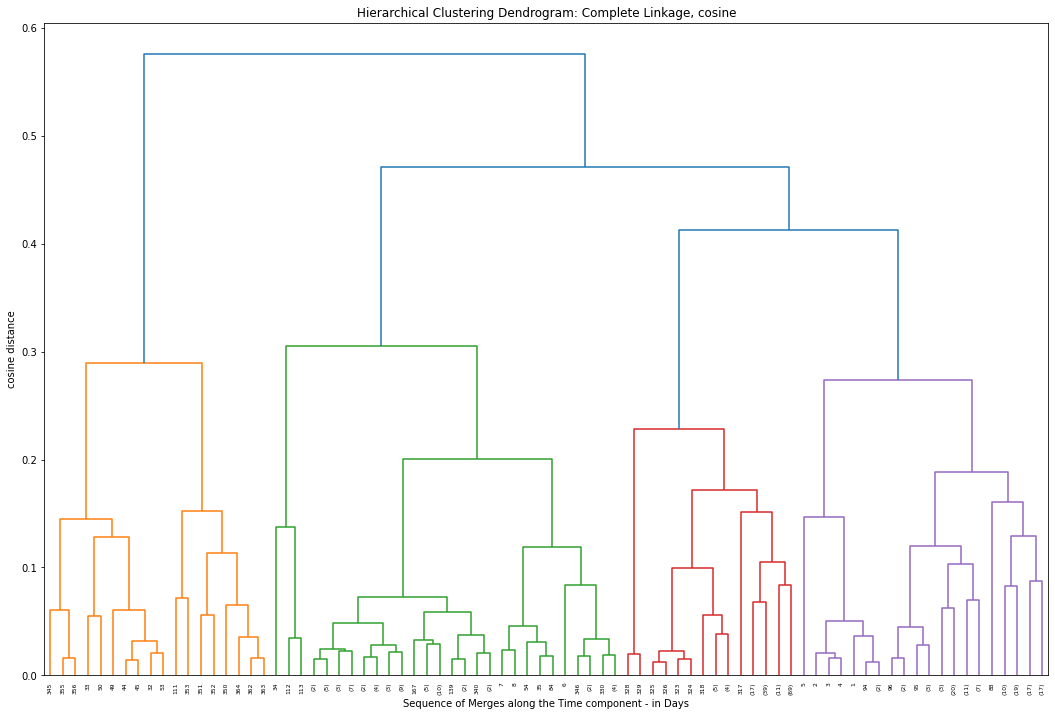

[2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 0 0 0 2 2 2 2 2 2 2 2 2 2 2]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,12.17,29.78,31.33,33.82,26.8,29.66,18.0
1,29.78,10.6,40.44,32.72,31.35,35.99,32.75
2,31.33,40.44,21.92,40.94,34.04,33.35,26.12
3,33.82,32.72,40.94,0.0,34.24,36.93,35.75
4,26.8,31.35,34.04,34.24,0.0,32.54,24.17
5,29.66,35.99,33.35,36.93,32.54,0.0,28.76
6,18.0,32.75,26.12,35.75,24.17,28.76,0.0



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.87,0.288959,-0.016423,-0.064626,0.422705,0.104988,0.652873
1,0.288959,0.93,0.234977,0.036309,0.356352,0.073809,0.256391
2,-0.016423,0.234977,0.45,0.345204,0.466971,-0.296179,-0.004213
3,-0.064626,0.036309,0.345204,1.0,0.163409,-0.060491,-0.003597
4,0.422705,0.356352,0.466971,0.163409,1.0,0.220289,0.599757
5,0.104988,0.073809,-0.296179,-0.060491,0.220289,1.0,0.112793
6,0.652873,0.256391,-0.004213,-0.003597,0.599757,0.112793,1.0




For n_clusters = 7 The average silhouette score is : 0.09106550097853305


For n_clusters = 7 The average davies bouldin score is : 0.778459560380153


For n_clusters = 7 The average calinski harabasz score is : 4.275638845262468


2    355
1      3
0      3
3      1
4      1
5      1
6      1
Name: Cluster, dtype: int64


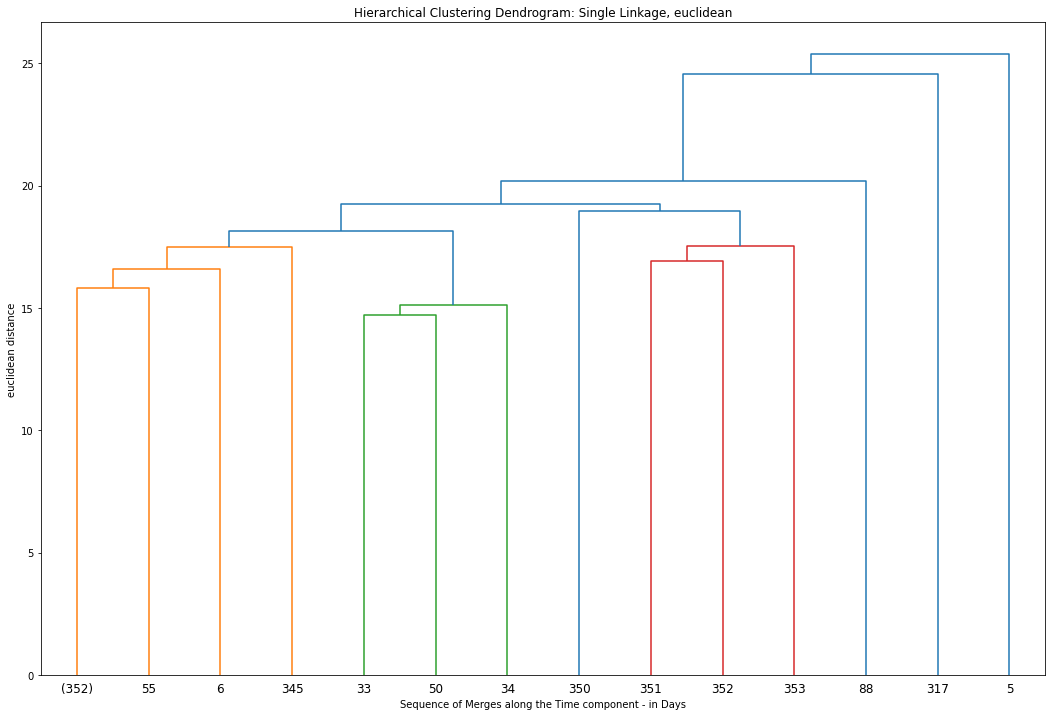

[1 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 1 1
 1 1 1 1 1 1 1 5 5 1 1 1 5 5 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 5 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 2 2
 2 2 1 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 6 6 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 5 2 2 1 1 0 0 0 0 1 5 5 1 1 1 1 1 0 0 0]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,16.12,25.09,35.97,34.85,31.53,21.8,41.82
1,25.09,15.88,27.91,36.87,40.58,29.04,39.55
2,35.97,27.91,16.03,44.78,33.62,41.21,33.53
3,34.85,36.87,44.78,12.85,34.29,31.4,25.89
4,31.53,40.58,33.62,34.29,0.0,33.69,31.42
5,21.8,29.04,41.21,31.4,33.69,15.76,41.17
6,41.82,39.55,33.53,25.89,31.42,41.17,5.53



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.81,0.460696,-0.526094,-0.228571,-0.028117,0.554986,-0.743644
1,0.460696,0.84,-0.117886,0.399726,-0.448851,0.479266,-0.282619
2,-0.526094,-0.117886,0.61,0.155267,0.163701,-0.432428,0.374657
3,-0.228571,0.399726,0.155267,0.81,-0.041549,0.054379,0.545612
4,-0.028117,-0.448851,0.163701,-0.041549,1.0,-0.003112,0.125506
5,0.554986,0.479266,-0.432428,0.054379,-0.003112,0.85,-0.465367
6,-0.743644,-0.282619,0.374657,0.545612,0.125506,-0.465367,0.98




For n_clusters = 7 The average silhouette score is : 0.2949752655838362


For n_clusters = 7 The average davies bouldin score is : 1.0301533535177927


For n_clusters = 7 The average calinski harabasz score is : 59.42106562874797


2    195
1    143
5     13
0      9
3      2
6      2
4      1
Name: Cluster, dtype: int64


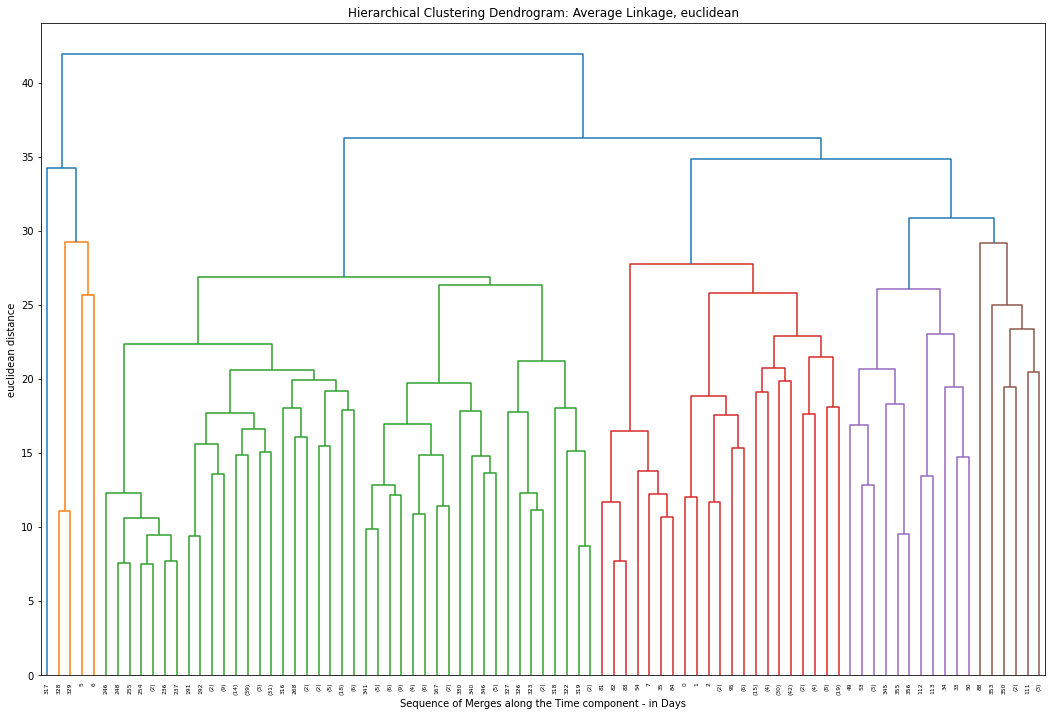

[1 1 1 1 1 1 0 0 3 3 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 2 2 2 3 3 2 4 4 0 0 3
 2 2 2 2 2 2 2 4 4 2 2 2 4 4 2 2 4 0 3 3 3 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 2 3 3 3 0 3 3 3 1 1 3 3 1 1 1 2 2 2 3 2 2 2 2 3 3 3 3 6 3 3 3
 4 4 4 3 3 3 3 3 3 3 3 3 6 6 3 3 3 3 3 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 6 6 6 6 6 1 1 1 1 6 0 0 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 1 1 1 4 2 4 4 2 2 2 2 2 2 2 4]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,19.45,26.49,33.94,27.98,27.92,38.91,25.15
1,26.49,18.02,20.59,21.25,28.76,34.19,24.79
2,33.94,20.59,14.15,14.71,24.2,35.77,24.49
3,27.98,21.25,14.71,13.09,30.66,34.08,16.61
4,27.92,28.76,24.2,30.66,16.18,43.37,33.88
5,38.91,34.19,35.77,34.08,43.37,13.17,20.18
6,25.15,24.79,24.49,16.61,33.88,20.18,13.49



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.7,0.024685,0.042095,0.501266,0.131821,-0.140578,0.755063
1,0.024685,0.72,0.655916,0.657742,0.09028,-0.239599,0.300937
2,0.042095,0.655916,0.88,0.821885,0.669159,-0.460162,0.357598
3,0.501266,0.657742,0.821885,0.9,0.399095,-0.333854,0.784325
4,0.131821,0.09028,0.669159,0.399095,0.83,-0.516825,0.065459
5,-0.140578,-0.239599,-0.460162,-0.333854,-0.516825,0.72,0.134037
6,0.755063,0.300937,0.357598,0.784325,0.065459,0.134037,0.77




For n_clusters = 7 The average silhouette score is : 0.22602973409617097


For n_clusters = 7 The average davies bouldin score is : 1.500811358458193


For n_clusters = 7 The average calinski harabasz score is : 96.15595671739719


5    142
6     73
3     70
2     38
1     18
4     15
0      9
Name: Cluster, dtype: int64


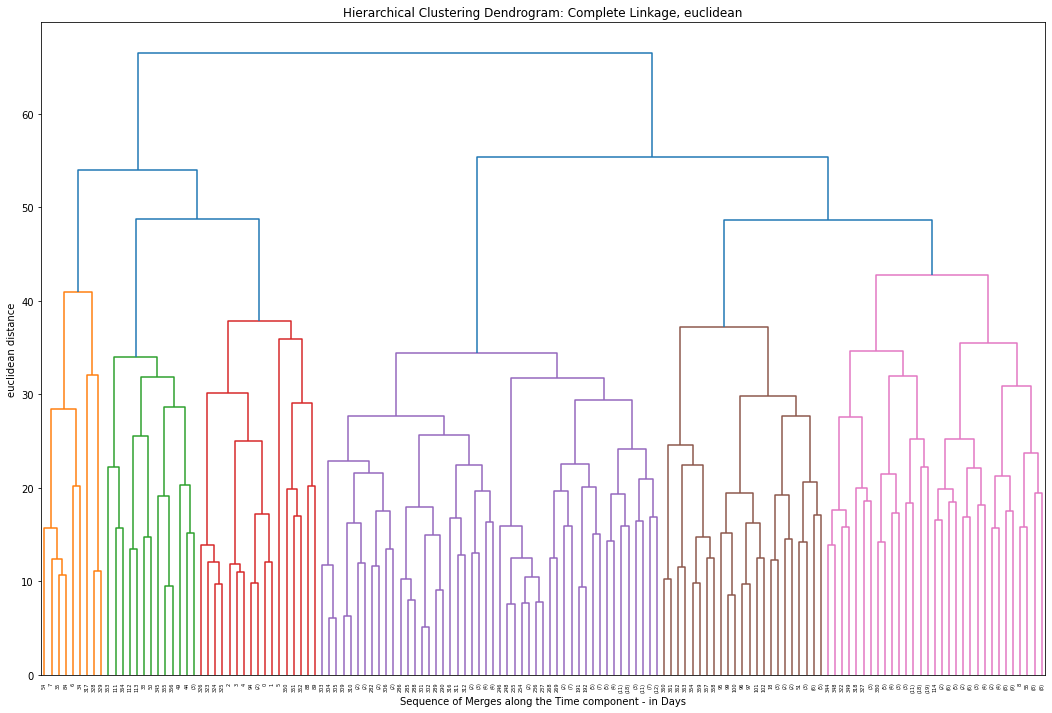

[0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 5 5 5 5 0 0 0 0 0 5 5 5 0 0 5 3 3 2 2 0
 5 5 5 5 5 5 5 3 3 0 0 5 3 3 5 5 3 2 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 6 6 0 0 2 6
 6 6 0 2 2 6 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1
 4 4 4 4 4 4 4 4 4 4 1 1 4 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 1 1 1 1 1 1 1 1 1 4 4 4 4
 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 2 6 6 6
 6 6 6 6 6 6 6 2 6 6 6 0 3 2 6 1 1 3 3 3 3 5 3 3 5 5 5 5 5 5 5 3]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,14.74,25.55,22.9,28.4,34.21,16.37,19.26
1,25.55,14.34,31.76,35.58,13.35,28.85,19.12
2,22.9,31.76,17.85,25.21,36.19,32.2,21.14
3,28.4,35.58,25.21,17.57,43.94,23.56,35.46
4,34.21,13.35,36.19,43.94,11.81,39.45,20.66
5,16.37,28.85,32.2,23.56,39.45,12.42,30.4
6,19.26,19.12,21.14,35.46,20.66,30.4,10.72



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.87,0.010444,0.592458,0.400627,-0.334837,0.772229,0.590698
1,0.010444,0.57,-0.316595,-0.378075,0.611413,-0.061323,-0.009797
2,0.592458,-0.316595,0.76,0.184812,0.005276,0.126684,0.877952
3,0.400627,-0.378075,0.184812,0.77,-0.57157,0.727182,-0.110304
4,-0.334837,0.611413,0.005276,-0.57157,0.83,-0.593121,0.301021
5,0.772229,-0.061323,0.126684,0.727182,-0.593121,0.91,0.037621
6,0.590698,-0.009797,0.877952,-0.110304,0.301021,0.037621,0.86




For n_clusters = 7 The average silhouette score is : 0.17941673013457174


For n_clusters = 7 The average davies bouldin score is : 1.5302466839463293


For n_clusters = 7 The average calinski harabasz score is : 99.05013150050554


0    112
4     96
1     58
6     34
5     27
2     20
3     18
Name: Cluster, dtype: int64


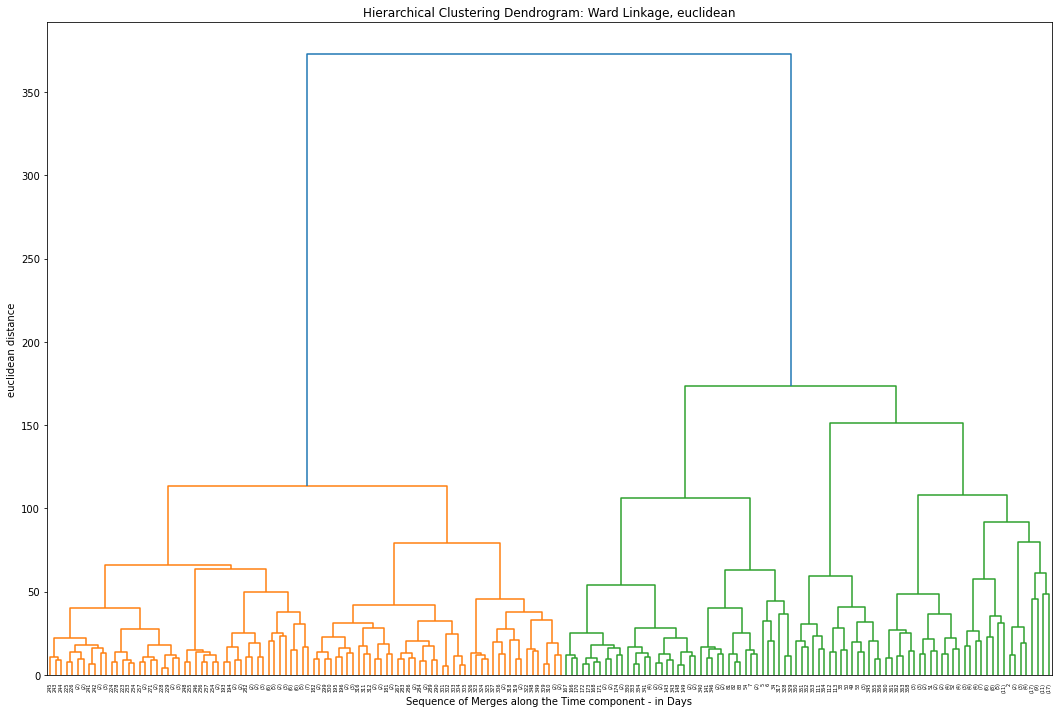

[0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 6 1 1 1 0 0 0 0 0 0 0 0 0 0 0]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,21.95,31.29,40.44,33.35,26.46,40.92,26.09
1,31.29,12.17,29.78,29.66,31.76,33.82,18.0
2,40.44,29.78,10.6,35.99,25.29,32.72,32.75
3,33.35,29.66,35.99,0.0,27.55,36.93,28.76
4,26.46,31.76,25.29,27.55,0.0,36.28,26.02
5,40.92,33.82,32.72,36.93,36.28,0.0,35.75
6,26.09,18.0,32.75,28.76,26.02,35.75,0.0



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.45,-0.012726,0.232754,-0.295195,0.11634,0.344982,-0.000749
1,-0.012726,0.87,0.288959,0.104988,-0.076855,-0.064626,0.652873
2,0.232754,0.288959,0.93,0.073809,0.726622,0.036309,0.256391
3,-0.295195,0.104988,0.073809,1.0,0.261801,-0.060491,0.112793
4,0.11634,-0.076855,0.726622,0.261801,1.0,0.080682,0.186129
5,0.344982,-0.064626,0.036309,-0.060491,0.080682,1.0,-0.003597
6,-0.000749,0.652873,0.256391,0.112793,0.186129,-0.003597,1.0




For n_clusters = 7 The average silhouette score is : 0.07483843318505241


For n_clusters = 7 The average davies bouldin score is : 0.802270473039831


For n_clusters = 7 The average calinski harabasz score is : 4.124191646382197


0    355
2      3
1      3
5      1
3      1
4      1
6      1
Name: Cluster, dtype: int64


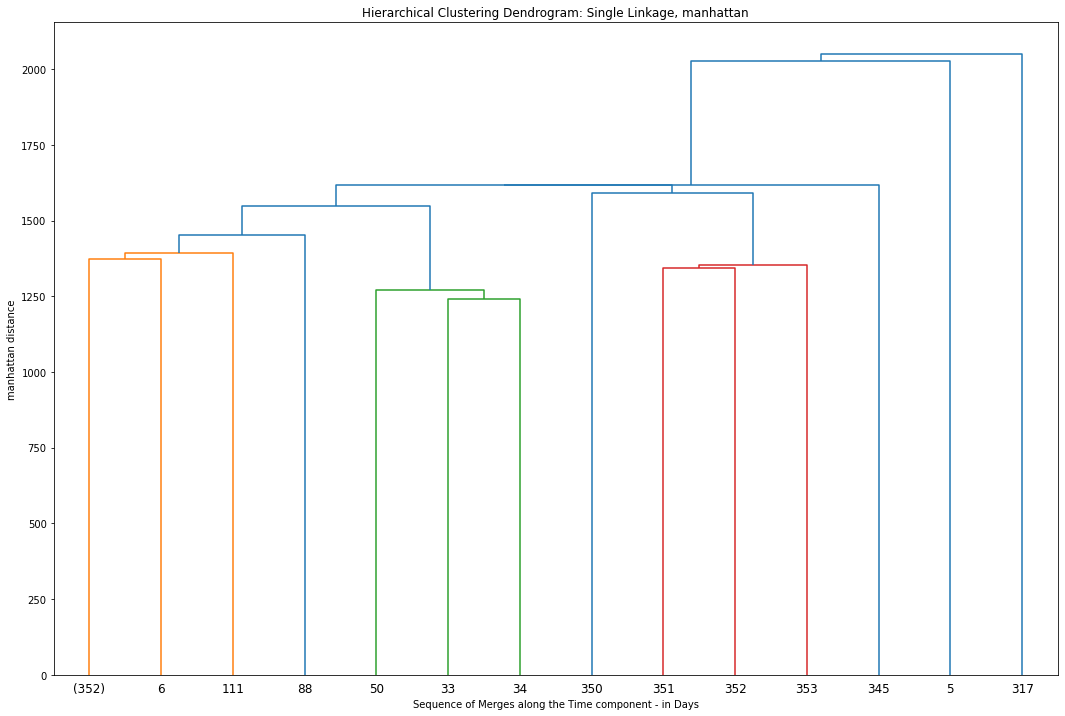

[2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 2 2
 2 2 2 2 2 2 2 6 6 2 2 2 6 6 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 6 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 5 5 5 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 0 0 0 0 0 0 6 6 0 0 0 0 0 0 0 0]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,16.77,33.22,22.53,36.62,39.43,40.75,25.8
1,33.22,14.12,28.21,34.74,47.68,32.46,43.92
2,22.53,28.21,16.91,38.33,35.79,32.12,29.36
3,36.62,34.74,38.33,0.0,34.29,31.18,33.69
4,39.43,47.68,35.79,34.29,12.85,26.6,31.4
5,40.75,32.46,32.12,31.18,26.6,9.78,39.19
6,25.8,43.92,29.36,33.69,31.4,39.19,15.76



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.82,-0.45122,0.410695,-0.303853,-0.23176,-0.723834,0.505515
1,-0.45122,0.69,-0.248938,0.221704,-0.061,0.245045,-0.543988
2,0.410695,-0.248938,0.79,-0.395992,0.490681,-0.015181,0.442786
3,-0.303853,0.221704,-0.395992,1.0,-0.041549,0.082648,-0.003112
4,-0.23176,-0.061,0.490681,-0.041549,0.81,0.608555,0.054379
5,-0.723834,0.245045,-0.015181,0.082648,0.608555,0.94,-0.382734
6,0.505515,-0.543988,0.442786,-0.003112,0.054379,-0.382734,0.85




For n_clusters = 7 The average silhouette score is : 0.2680090816958556


For n_clusters = 7 The average davies bouldin score is : 1.0409459497384694


For n_clusters = 7 The average calinski harabasz score is : 62.9961168945851


2    179
1    152
0     15
6     13
5      3
4      2
3      1
Name: Cluster, dtype: int64


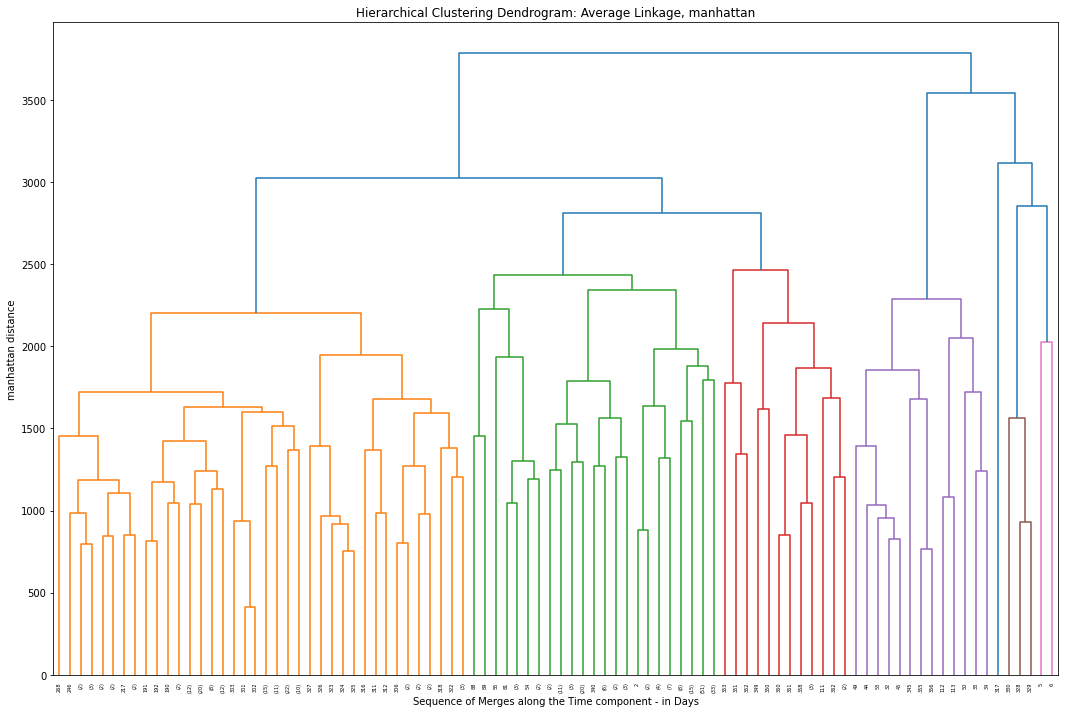

[2 2 2 2 2 4 4 0 0 2 2 2 2 2 2 2 2 6 2 6 2 2 2 6 6 6 6 6 2 2 2 6 1 4 4 0 2
 2 2 6 6 6 6 6 1 1 2 2 6 1 1 6 6 1 0 0 2 2 2 2 2 2 2 0 2 2 2 2 2 0 0 2 2 2
 2 2 2 0 0 0 2 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 6
 1 4 4 2 2 2 2 2 2 2 2 2 0 0 2 6 2 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0
 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 0 5 5 5 5 5 5 5 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 6 1 1 6 6 6 6 6 6 1 1]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,15.25,31.51,15.75,23.38,31.65,21.68,25.9
1,31.51,17.43,26.76,41.24,22.37,32.96,24.86
2,15.75,26.76,14.68,33.82,31.13,28.35,15.76
3,23.38,41.24,33.82,13.1,45.6,23.44,35.76
4,31.65,22.37,31.13,45.6,18.21,32.69,38.26
5,21.68,32.96,28.35,23.44,32.69,16.28,34.47
6,25.9,24.86,15.76,35.76,38.26,34.47,11.39



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.78,0.035334,0.767884,0.009533,0.582773,0.087949,0.320835
1,0.035334,0.78,0.436312,-0.573426,0.503382,-0.644166,0.708832
2,0.767884,0.436312,0.87,-0.327968,0.489469,-0.116681,0.814891
3,0.009533,-0.573426,-0.327968,0.72,-0.279561,0.365921,-0.471382
4,0.582773,0.503382,0.489469,-0.279561,0.72,-0.311295,0.274548
5,0.087949,-0.644166,-0.116681,0.365921,-0.311295,0.68,-0.414896
6,0.320835,0.708832,0.814891,-0.471382,0.274548,-0.414896,0.93




For n_clusters = 7 The average silhouette score is : 0.2194915398887893


For n_clusters = 7 The average davies bouldin score is : 1.5488921066965704


For n_clusters = 7 The average calinski harabasz score is : 88.02073417266931


3    138
2     84
0     84
6     25
1     16
5     12
4      6
Name: Cluster, dtype: int64


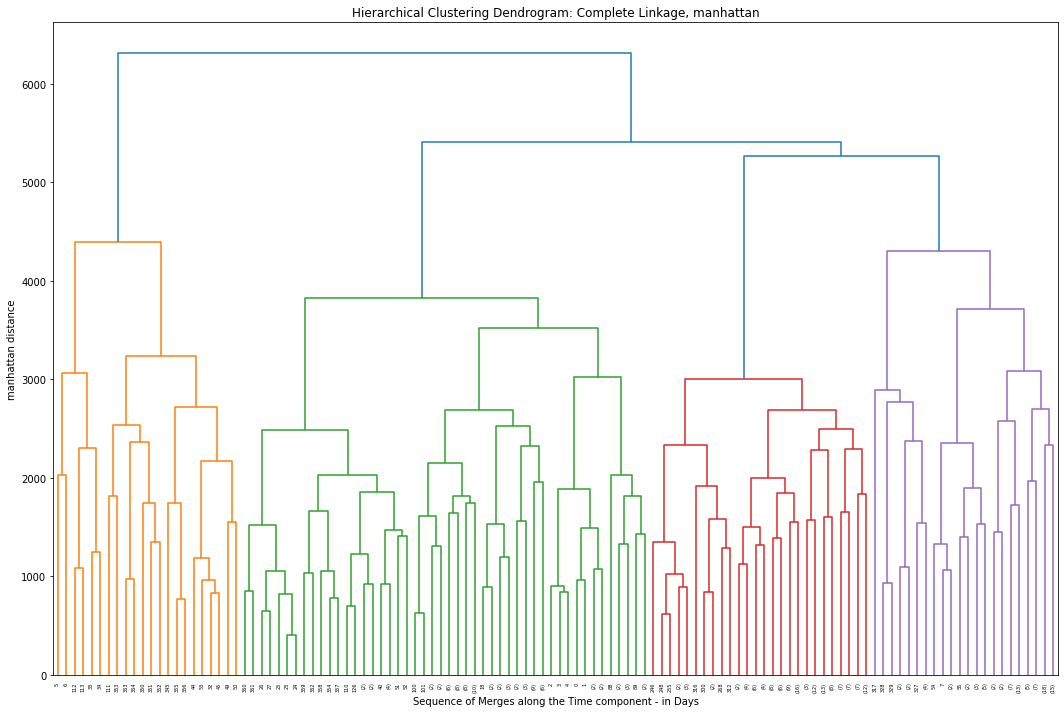

(            0         1         2         3         4         5         6  \
 0    0.769017  0.770259  0.771630  0.773273  0.775120  0.776958  0.779331   
 1    0.550508  0.553300  0.556458  0.559669  0.563267  0.567307  0.572538   
 2    0.406872  0.409658  0.412606  0.415610  0.419244  0.423269  0.428991   
 3    0.305465  0.310937  0.316694  0.322337  0.328391  0.335097  0.343577   
 4    0.421539  0.426288  0.431427  0.436308  0.441402  0.446999  0.453807   
 ..        ...       ...       ...       ...       ...       ...       ...   
 360  0.052561  0.051631  0.051313  0.050468  0.049699  0.049318  0.051388   
 361  0.000000  0.000000  0.000000  0.000000  0.000000  0.000273  0.003398   
 362  0.062689  0.061680  0.060901  0.059721  0.058980  0.058829  0.061220   
 363  0.013697  0.010000  0.007042  0.004333  0.001862  0.000000  0.000000   
 364  0.153705  0.144128  0.134847  0.125284  0.115881  0.106957  0.100221   
 
             7         8         9  ...     11758     11759   

In [11]:
st_agglomerative(path2,data, var, 7, 7, p=7, affinity="euclidean", linkage="average", transformation=True, dim_reduction=False)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 4 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,22.46,13.21,19.32,18.32,32.94,11.15,22.13
1,13.21,0.0,14.28,25.13,37.86,13.86,27.08
2,19.32,14.28,0.0,23.91,38.14,17.64,26.93
3,18.32,25.13,23.91,0.0,24.57,20.56,21.08
4,32.94,37.86,38.14,24.57,0.0,37.41,26.15
5,11.15,13.86,17.64,20.56,37.41,0.0,27.05
6,22.13,27.08,26.93,21.08,26.15,27.05,0.0



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.44,0.605846,0.268971,-0.143587,-0.287619,0.658882,0.036367
1,0.605846,1.0,0.678127,-0.424274,-0.569684,0.673732,-0.158861
2,0.268971,0.678127,1.0,-0.058506,-0.44463,0.561051,-0.001712
3,-0.143587,-0.424274,-0.058506,1.0,0.54224,-0.013518,0.22765
4,-0.287619,-0.569684,-0.44463,0.54224,1.0,-0.358044,0.410399
5,0.658882,0.673732,0.561051,-0.013518,-0.358044,1.0,-0.158957
6,0.036367,-0.158861,-0.001712,0.22765,0.410399,-0.158957,1.0




For n_clusters = 7 The average silhouette score is : -0.2753175796073932


For n_clusters = 7 The average davies bouldin score is : 1.3806971267162969


For n_clusters = 7 The average calinski harabasz score is : 0.8089576153318562


0    359
3      1
4      1
6      1
5      1
1      1
2      1
Name: Cluster, dtype: int64


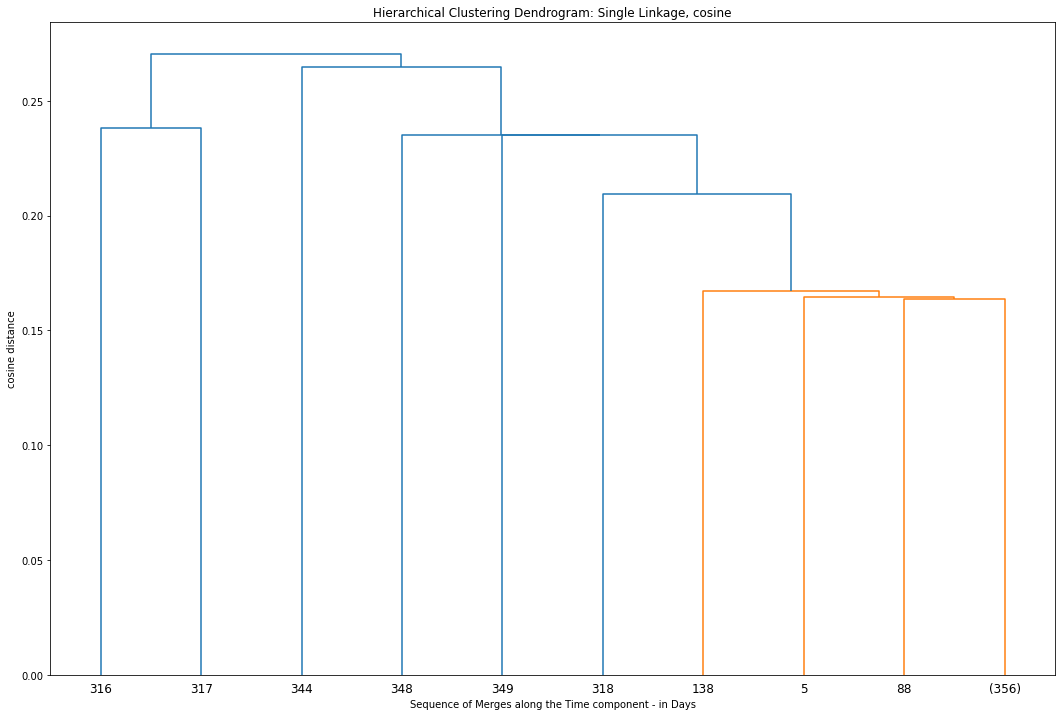

[0 0 0 0 0 5 1 1 0 0 0 0 0 0 0 0 0 0 6 0 6 0 0 0 0 0 0 0 0 0 0 0 6 6 1 1 0
 6 6 0 0 0 0 0 6 6 6 6 0 6 6 0 0 6 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 6 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 0 6 0 0 0 0 0 0 4 4 1 1 1 1 1 4 1 1 1
 1 1 1 1 1 1 1 1 1 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 6 1 1 0 0 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,14.93,18.86,32.55,27.45,16.07,28.3,18.74
1,18.86,14.32,27.08,21.67,18.71,27.88,24.9
2,32.55,27.08,13.36,22.16,19.9,34.0,35.88
3,27.45,21.67,22.16,15.16,24.13,23.39,31.39
4,16.07,18.71,19.9,24.13,6.71,32.28,26.79
5,28.3,27.88,34.0,23.39,32.28,19.56,20.86
6,18.74,24.9,35.88,31.39,26.79,20.86,18.85



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.87,0.623797,-0.296858,-0.026717,0.881234,0.157055,0.699861
1,0.623797,0.88,0.043978,0.161549,0.699166,-0.19983,0.27913
2,-0.296858,0.043978,0.71,0.359933,0.078129,-0.284055,-0.475378
3,-0.026717,0.161549,0.359933,0.71,0.123631,-0.232513,-0.579857
4,0.881234,0.699166,0.078129,0.123631,0.93,-0.033256,0.459649
5,0.157055,-0.19983,-0.284055,-0.232513,-0.033256,0.6,0.407222
6,0.699861,0.27913,-0.475378,-0.579857,0.459649,0.407222,0.79




For n_clusters = 7 The average silhouette score is : 0.15506944536967404


For n_clusters = 7 The average davies bouldin score is : 1.3920554111795682


For n_clusters = 7 The average calinski harabasz score is : 95.92124461356582


2    155
0    111
1     41
6     31
3     13
5      7
4      7
Name: Cluster, dtype: int64


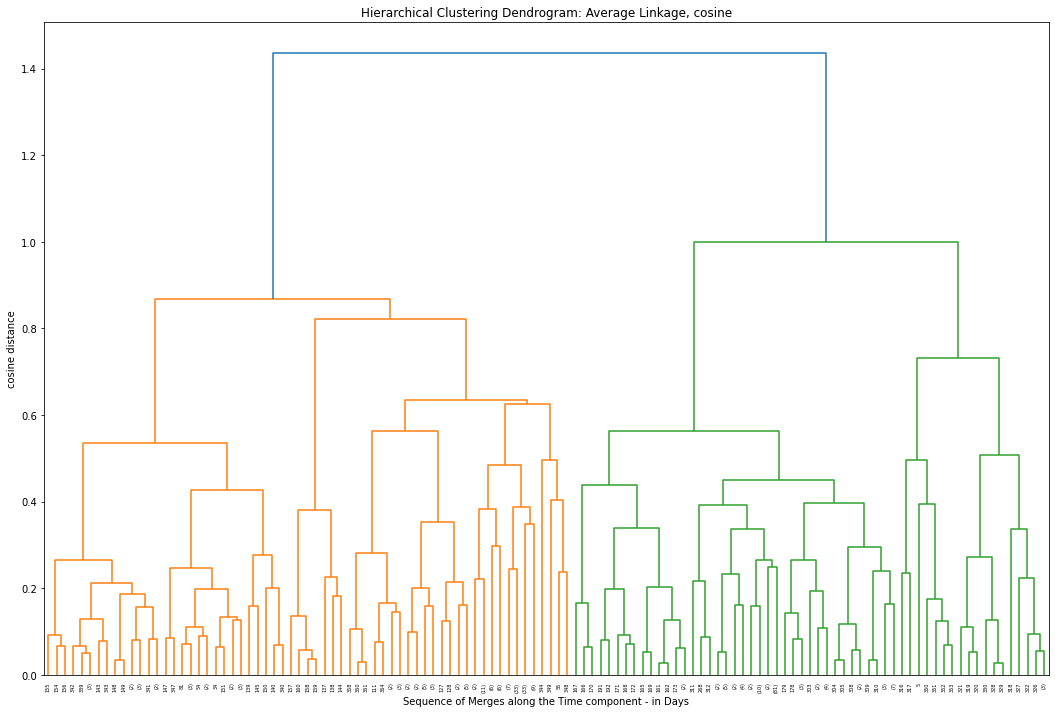

[3 3 3 3 3 3 0 0 2 2 2 2 2 2 2 2 2 3 2 3 2 2 2 2 2 2 3 3 3 2 2 3 0 0 0 0 2
 2 2 3 3 3 3 3 0 0 2 2 3 0 0 3 3 0 2 3 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 3 3 3 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2
 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 6 6 2 0 0 6
 6 6 0 0 0 6 6 6 6 1 1 1 1 1 1 6 6 6 1 1 6 6 1 6 6 6 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 4 4 4 4 4 4 4 4 4 4 4 4 6 6 6
 6 6 6 6 6 6 6 0 6 6 6 3 0 0 6 3 4 0 0 0 0 3 0 0 3 3 3 3 3 3 3 0]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,21.0,28.93,21.91,21.69,25.9,34.83,25.65
1,28.93,12.55,25.05,30.09,20.02,11.2,11.99
2,21.91,25.05,13.74,13.22,27.18,32.94,19.26
3,21.69,30.09,13.22,17.74,26.52,34.78,27.8
4,25.9,20.02,27.18,26.52,15.22,22.82,21.51
5,34.83,11.2,32.94,34.78,22.82,13.05,21.8
6,25.65,11.99,19.26,27.8,21.51,21.8,9.71



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.6,0.086173,0.638537,0.501479,-0.484625,-0.393923,0.390961
1,0.086173,0.75,0.29928,-0.100976,0.304599,0.704269,0.756025
2,0.638537,0.29928,0.89,0.84554,-0.010071,-0.311471,0.632221
3,0.501479,-0.100976,0.84554,0.81,-0.051179,-0.449412,0.154233
4,-0.484625,0.304599,-0.010071,-0.051179,0.7,0.28695,0.215806
5,-0.393923,0.704269,-0.311471,-0.449412,0.28695,0.72,0.132407
6,0.390961,0.756025,0.632221,0.154233,0.215806,0.132407,0.9




For n_clusters = 7 The average silhouette score is : 0.15541224689032224


For n_clusters = 7 The average davies bouldin score is : 1.8018720632575318


For n_clusters = 7 The average calinski harabasz score is : 97.65762091393387


5    136
2     97
3     39
0     34
6     31
1     15
4     13
Name: Cluster, dtype: int64


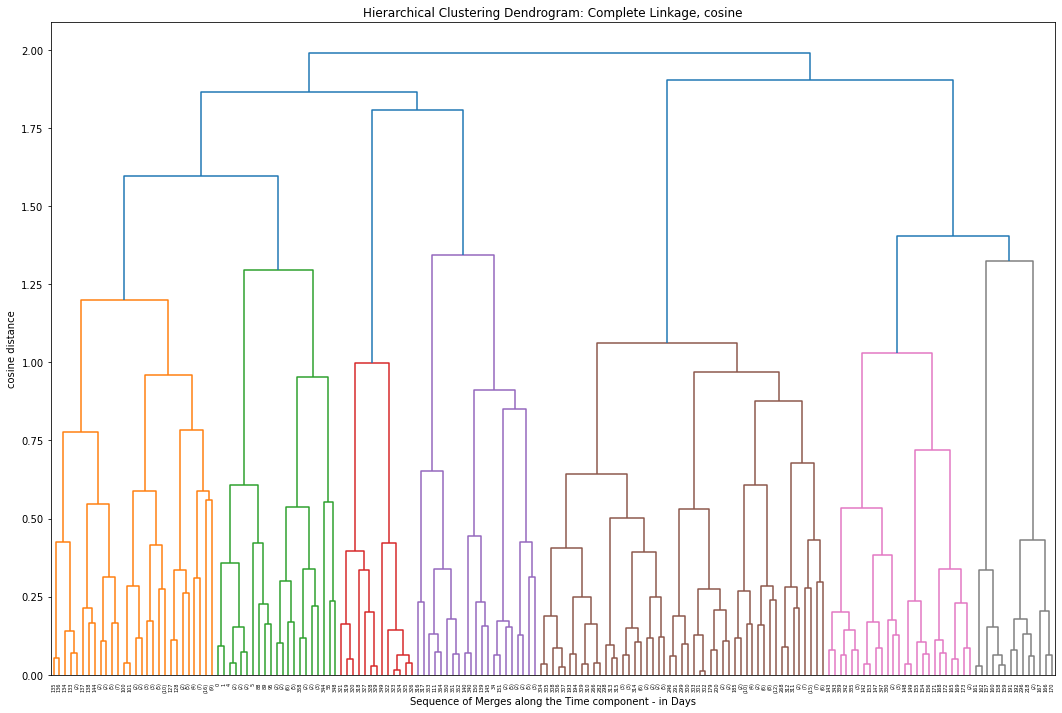

[2 2 2 2 2 3 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,13.11,29.41,28.94,33.41,24.98,28.38,35.99
1,29.41,0.0,26.28,36.28,32.13,27.55,36.51
2,28.94,26.28,22.08,40.84,33.91,33.27,39.91
3,33.41,36.28,40.84,0.0,34.24,36.93,25.7
4,24.98,32.13,33.91,34.24,0.0,32.54,35.98
5,28.38,27.55,33.27,36.93,32.54,0.0,36.31
6,35.99,36.51,39.91,25.7,35.98,36.31,0.0



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.84,-0.015524,-0.006545,-0.05364,0.496916,0.114251,-0.247217
1,-0.015524,1.0,0.129444,0.080682,0.245738,0.261801,0.049138
2,-0.006545,0.129444,0.45,0.34288,0.471541,-0.295497,0.362892
3,-0.05364,0.080682,0.34288,1.0,0.163409,-0.060491,0.307247
4,0.496916,0.245738,0.471541,0.163409,1.0,0.220289,0.074618
5,0.114251,0.261801,-0.295497,-0.060491,0.220289,1.0,-0.008442
6,-0.247217,0.049138,0.362892,0.307247,0.074618,-0.008442,1.0




For n_clusters = 7 The average silhouette score is : 0.08136292167106882


For n_clusters = 7 The average davies bouldin score is : 0.7542286466265608


For n_clusters = 7 The average calinski harabasz score is : 3.280703735142655


2    356
0      4
3      1
6      1
4      1
5      1
1      1
Name: Cluster, dtype: int64


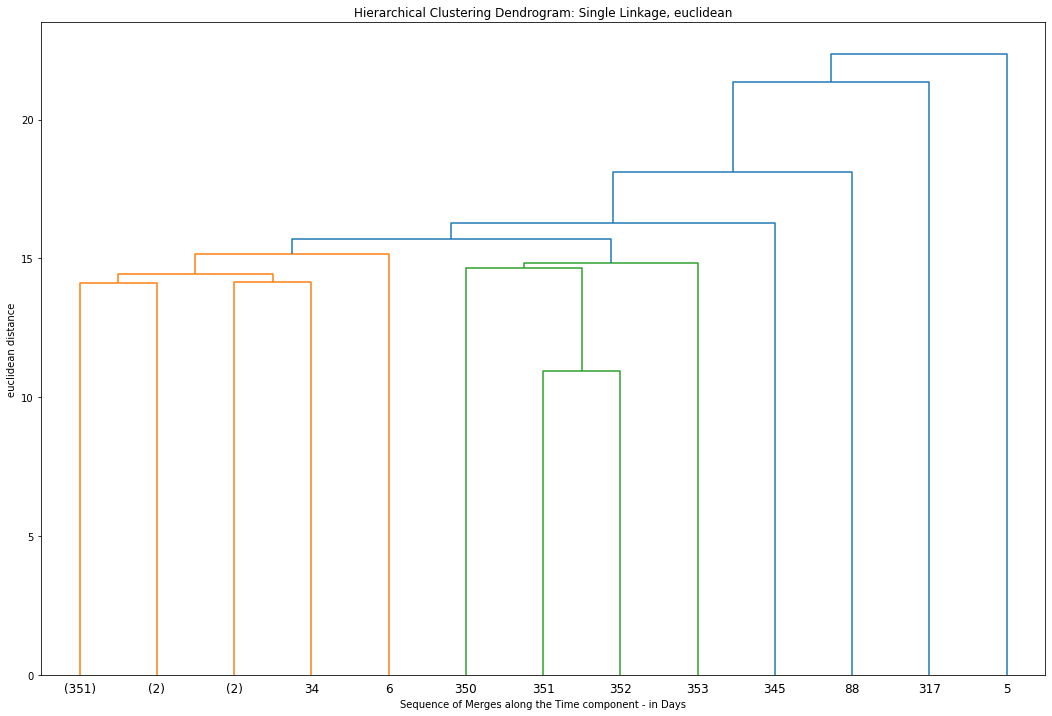

[1 1 1 1 1 4 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 6 3 3 1
 1 1 1 1 1 1 1 6 6 1 1 1 6 6 1 1 6 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 1 1 5 5
 5 5 1 5 5 5 5 5 5 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 5 0 0 0 0 0 0 0 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 1 6 5 5 1 1 2 2 2 2 1 6 6 1 1 1 1 1 2 2 2]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,16.59,27.57,28.89,32.97,32.62,20.16,36.07
1,27.57,15.57,25.09,30.37,39.45,28.31,28.98
2,28.89,25.09,16.12,34.31,34.84,36.55,21.07
3,32.97,30.37,34.31,12.63,30.43,41.32,26.34
4,32.62,39.45,34.84,30.43,0.0,47.99,34.86
5,20.16,28.31,36.55,41.32,47.99,15.62,41.49
6,36.07,28.98,21.07,26.34,34.86,41.49,14.69



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.63,-0.185139,-0.388512,-0.110342,0.455244,0.390048,-0.669815
1,-0.185139,0.85,0.471063,0.539956,0.341575,-0.115408,0.477648
2,-0.388512,0.471063,0.81,-0.080369,-0.001077,-0.52342,0.591127
3,-0.110342,0.539956,-0.080369,0.92,0.218606,0.042701,0.43388
4,0.455244,0.341575,-0.001077,0.218606,1.0,0.050167,0.023655
5,0.390048,-0.115408,-0.52342,0.042701,0.050167,0.62,-0.421995
6,-0.669815,0.477648,0.591127,0.43388,0.023655,-0.421995,0.87




For n_clusters = 7 The average silhouette score is : 0.2737465131304421


For n_clusters = 7 The average davies bouldin score is : 1.1089528400926516


For n_clusters = 7 The average calinski harabasz score is : 74.61017936116552


5    186
1    139
0     13
6     12
2      9
3      5
4      1
Name: Cluster, dtype: int64


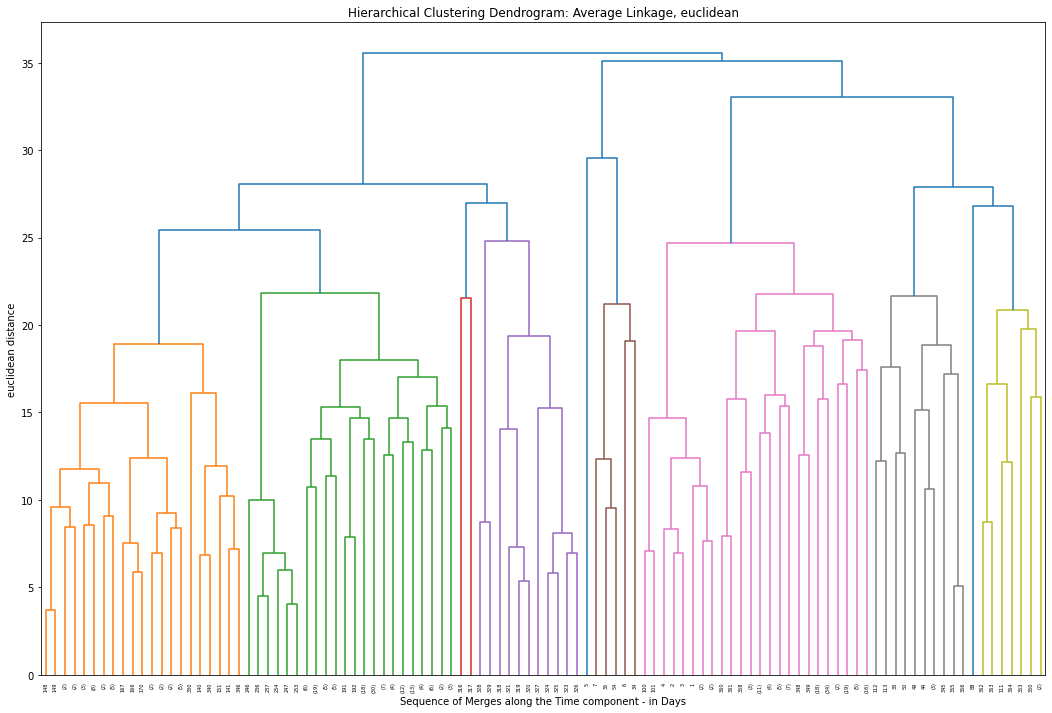

[5 5 5 5 5 1 1 1 3 3 3 3 3 3 3 3 3 5 3 5 3 3 3 5 5 5 5 5 5 3 3 5 6 6 1 1 3
 3 3 5 5 5 5 5 6 6 3 3 5 6 6 5 5 6 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 5 3 3 5 5 5 5 5 5 3 5 5 5 5 3 3 3 3 2 3 5 5
 0 6 6 3 3 3 3 3 3 3 3 3 2 2 3 5 3 3 3 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 3 2 2
 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 2 2 2 2 4 2 2 2 2 2 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 3 3 0 0 0 0 5 6 6 5 5 5 5 5 0 0 0]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,18.86,29.82,28.16,26.44,34.58,21.92,19.83
1,29.82,18.9,27.68,28.1,41.39,35.21,28.53
2,28.16,27.68,14.46,16.5,19.63,23.77,35.17
3,26.44,28.1,16.5,13.56,33.86,14.13,29.57
4,34.58,41.39,19.63,33.86,13.14,34.88,45.56
5,21.92,35.21,23.77,14.13,34.88,15.24,29.53
6,19.83,28.53,35.17,29.57,45.56,29.53,14.37



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.67,-0.287847,-0.191821,0.2867,-0.427964,0.584072,0.665158
1,-0.287847,0.73,0.746996,0.54342,-0.150381,0.060935,0.186387
2,-0.191821,0.746996,0.73,0.781609,0.160888,0.3719,0.093037
3,0.2867,0.54342,0.781609,0.89,-0.332824,0.826379,0.480966
4,-0.427964,-0.150381,0.160888,-0.332824,0.72,-0.404016,-0.537573
5,0.584072,0.060935,0.3719,0.826379,-0.404016,0.87,0.492353
6,0.665158,0.186387,0.093037,0.480966,-0.537573,0.492353,0.88




For n_clusters = 7 The average silhouette score is : 0.24405872834475767


For n_clusters = 7 The average davies bouldin score is : 1.4772837229426077


For n_clusters = 7 The average calinski harabasz score is : 107.02392702300145


4    142
3     79
2     71
5     42
0     12
6     11
1      8
Name: Cluster, dtype: int64


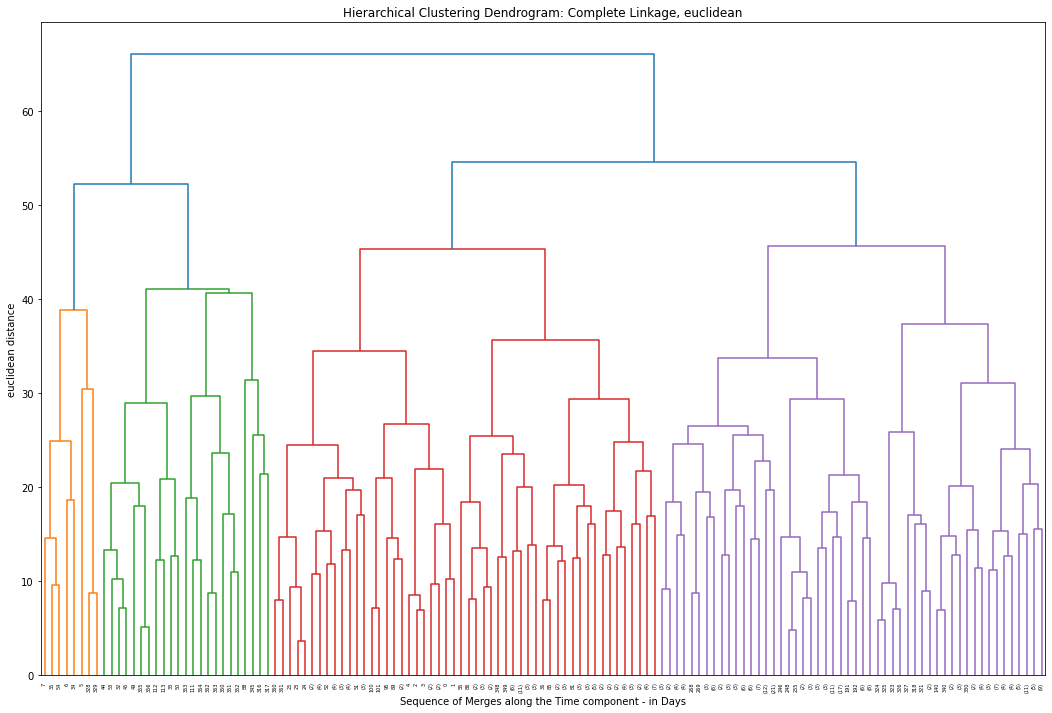

[2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 5 0 5 0 0 0 0 0 0 5 5 5 0 0 5 3 3 2 0 0
 0 0 5 5 5 5 5 3 3 0 0 5 3 3 5 5 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 2 2 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 0 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 6 6 6 6 6 6 6 6 6
 1 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 6 1 1 1 1 1 1 1 1 1 1 1 6 1 1 1 6 6 6 6 6 6 6 6 6 1 1 1 1
 1 1 6 6 6 6 6 6 6 6 1 1 1 1 1 6 6 6 6 6 6 2 2 2 2 2 6 2 2 2 2 2 2 2 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 0 3 4 4 2 2 3 3 3 3 5 3 3 5 5 5 5 5 5 5 3]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,14.28,35.02,20.99,27.14,17.88,18.16,28.94
1,35.02,12.31,30.81,43.66,21.35,39.57,11.87
2,20.99,30.81,21.03,27.61,21.27,27.58,26.16
3,27.14,43.66,27.61,17.96,32.99,24.56,36.47
4,17.88,21.35,21.27,32.99,12.0,30.1,20.95
5,18.16,39.57,27.58,24.56,30.1,11.68,29.55
6,28.94,11.87,26.16,36.47,20.95,29.55,11.43



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.88,-0.351049,0.55134,0.477871,0.675061,0.734544,-0.116195
1,-0.351049,0.81,-0.065098,-0.600973,0.253949,-0.612097,0.642277
2,0.55134,-0.065098,0.59,-0.162527,0.382349,0.26509,0.041923
3,0.477871,-0.600973,-0.162527,0.76,0.013085,0.712442,-0.14575
4,0.675061,0.253949,0.382349,0.013085,0.84,0.056284,-0.092349
5,0.734544,-0.612097,0.26509,0.712442,0.056284,0.92,0.039008
6,-0.116195,0.642277,0.041923,-0.14575,-0.092349,0.039008,0.67




For n_clusters = 7 The average silhouette score is : 0.2055804333881765


For n_clusters = 7 The average davies bouldin score is : 1.438616052021174


For n_clusters = 7 The average calinski harabasz score is : 116.83074307788857


0    104
1    101
4     51
6     42
2     26
5     22
3     19
Name: Cluster, dtype: int64


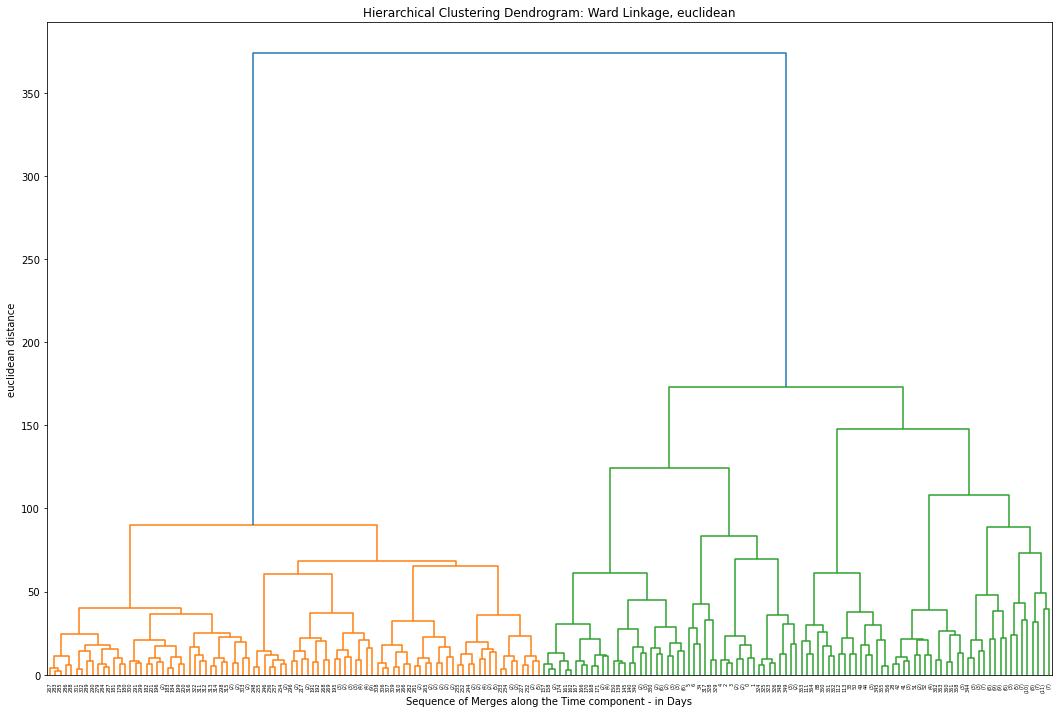

[0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,22.07,28.95,26.32,33.92,33.28,40.83,42.71
1,28.95,13.11,29.41,24.98,28.38,33.41,36.11
2,26.32,29.41,0.0,32.13,27.55,36.28,29.8
3,33.92,24.98,32.13,0.0,32.54,34.24,36.0
4,33.28,28.38,27.55,32.54,0.0,36.93,36.21
5,40.83,33.41,36.28,34.24,36.93,0.0,32.95
6,42.71,36.11,29.8,36.0,36.21,32.95,0.0



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.45,-0.008129,0.12515,0.47033,-0.29683,0.344029,0.27552
1,-0.008129,0.84,-0.015524,0.496916,0.114251,-0.05364,0.008962
2,0.12515,-0.015524,1.0,0.245738,0.261801,0.080682,0.614253
3,0.47033,0.496916,0.245738,1.0,0.220289,0.163409,0.21354
4,-0.29683,0.114251,0.261801,0.220289,1.0,-0.060491,0.178738
5,0.344029,-0.05364,0.080682,0.163409,-0.060491,1.0,0.091396
6,0.27552,0.008962,0.614253,0.21354,0.178738,0.091396,1.0




For n_clusters = 7 The average silhouette score is : 0.08400829040343077


For n_clusters = 7 The average davies bouldin score is : 0.7473777358000734


For n_clusters = 7 The average calinski harabasz score is : 3.388588369213088


0    356
1      4
5      1
6      1
3      1
4      1
2      1
Name: Cluster, dtype: int64


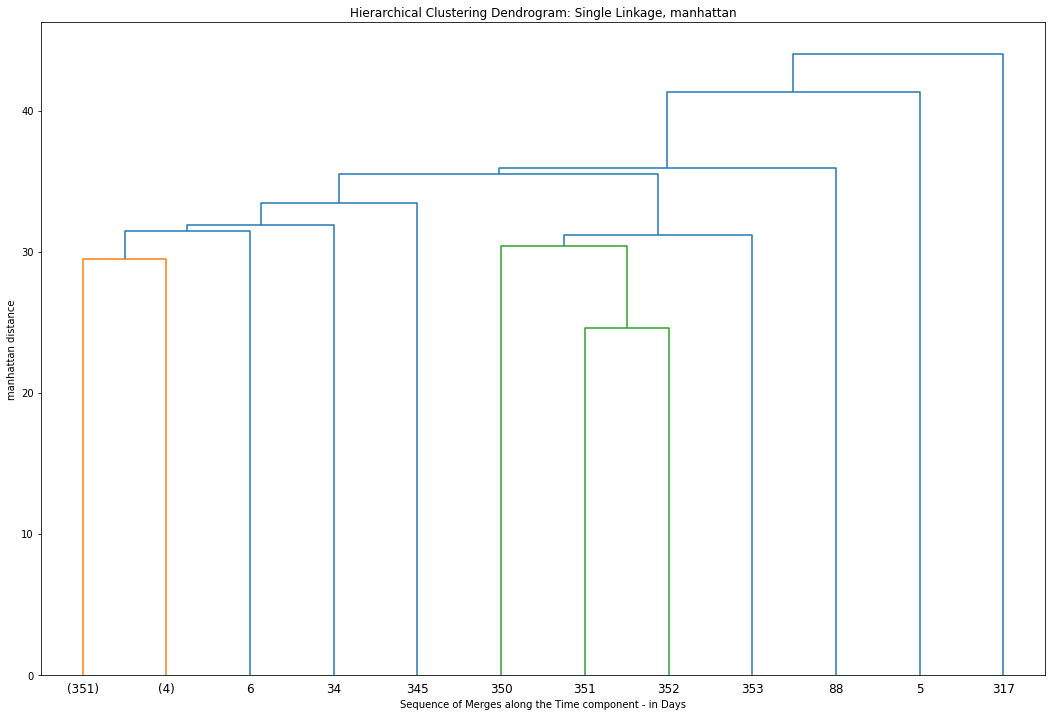

[2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 1 2 2
 2 2 2 2 2 2 2 3 3 2 2 2 3 3 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 0 6 6 6 6 6 5 5 5 5 5 5 5 5 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 4 4 4 2 3 3 2 2 2 2 2 2 2 2]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,16.27,28.09,29.65,27.05,23.11,28.16,37.4
1,28.09,15.47,35.25,29.49,31.81,30.67,48.01
2,29.65,35.25,17.22,28.98,30.47,26.77,28.92
3,27.05,29.49,28.98,13.84,26.08,37.54,44.58
4,23.11,31.81,30.47,26.08,12.17,30.63,39.77
5,28.16,30.67,26.77,37.54,30.63,15.85,25.6
6,37.4,48.01,28.92,44.58,39.77,25.6,13.58



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.78,0.176991,0.189857,0.300601,0.354552,-0.148828,-0.07994
1,0.176991,0.76,0.461295,0.279841,-0.102425,0.23023,-0.098679
2,0.189857,0.461295,0.78,0.456536,0.169737,-0.092374,-0.245017
3,0.300601,0.279841,0.456536,0.89,0.366168,-0.599205,-0.538231
4,0.354552,-0.102425,0.169737,0.366168,0.87,-0.323859,-0.34335
5,-0.148828,0.23023,-0.092374,-0.599205,-0.323859,0.71,0.284704
6,-0.07994,-0.098679,-0.245017,-0.538231,-0.34335,0.284704,0.7




For n_clusters = 7 The average silhouette score is : 0.32553182943555303


For n_clusters = 7 The average davies bouldin score is : 1.0737507611988608


For n_clusters = 7 The average calinski harabasz score is : 74.95541887863982


2    178
6    160
3     11
5      8
1      3
4      3
0      2
Name: Cluster, dtype: int64


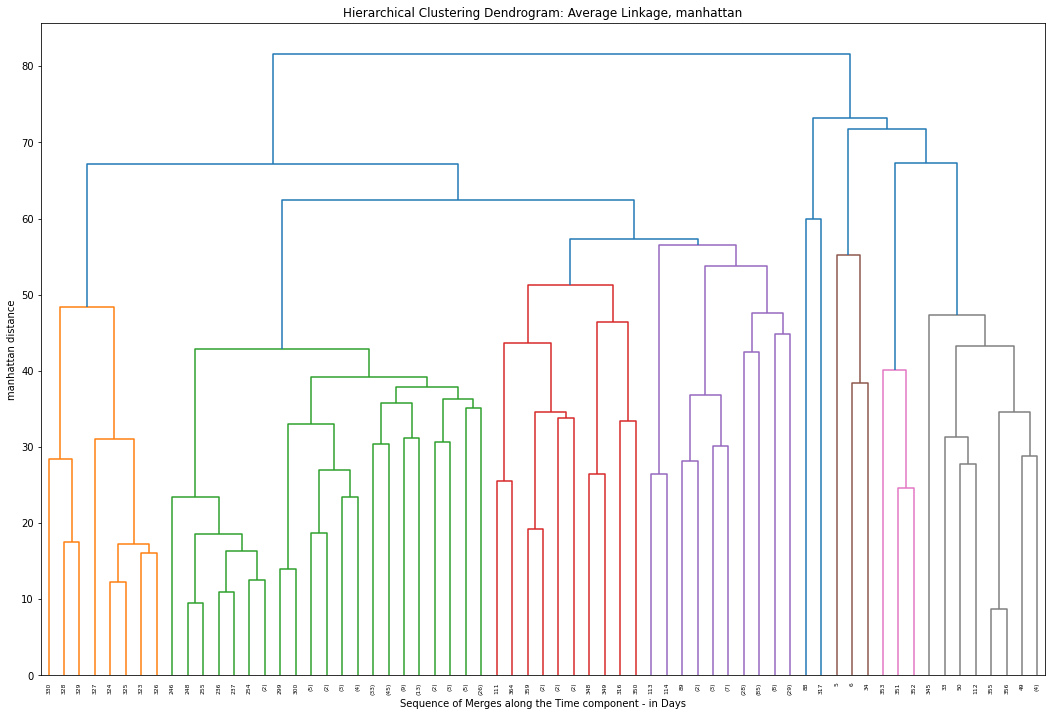

[0 0 2 2 2 4 4 0 6 6 6 0 6 0 0 6 0 2 0 2 0 0 0 0 0 0 2 2 2 0 0 2 5 5 4 0 6
 0 0 2 2 2 2 2 5 5 0 0 2 5 5 2 2 5 0 6 6 6 2 0 2 0 2 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 0 6 6 6 6 6 6 2 6 6 6 6 2 2 2 6 6 2 2 2 2 2 2 2 0 0 0 0 0 0 2
 5 5 0 0 2 2 2 2 2 6 2 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1
 1 1 0 0 0 1 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 0 5 0 1 0 0 1 5 5 5 2 5 5 2 2 2 2 2 2 2 5]

This is the RMSE evaluation results:



,0,1,2,3,4,5,6
0,15.47,15.46,12.42,26.82,36.4,27.92,10.25
1,15.46,17.34,24.24,20.47,32.26,31.64,19.92
2,12.42,24.24,15.64,33.39,38.2,25.29,15.22
3,26.82,20.47,33.39,13.58,48.01,41.8,35.27
4,36.4,32.26,38.2,48.01,15.47,29.19,34.08
5,27.92,31.64,25.29,41.8,29.19,17.28,30.13
6,10.25,19.92,15.22,35.27,34.08,30.13,13.51



This is the Spatial Correlation evaluation results:



,0,1,2,3,4,5,6
0,0.82,0.59342,0.861812,-0.177879,0.491917,0.443163,0.966803
1,0.59342,0.62,0.19727,0.184783,0.710292,-0.177298,0.677452
2,0.861812,0.19727,0.84,-0.352919,0.164609,0.54833,0.813945
3,-0.177879,0.184783,-0.352919,0.7,-0.098679,-0.552577,-0.255289
4,0.491917,0.710292,0.164609,-0.098679,0.76,0.175103,0.563849
5,0.443163,-0.177298,0.54833,-0.552577,0.175103,0.79,0.354753
6,0.966803,0.677452,0.813945,-0.255289,0.563849,0.354753,0.9




For n_clusters = 7 The average silhouette score is : 0.23378055917781548


For n_clusters = 7 The average davies bouldin score is : 1.7203291683682989


For n_clusters = 7 The average calinski harabasz score is : 91.80442046908438


3    160
0     69
2     48
6     39
1     30
5     16
4      3
Name: Cluster, dtype: int64


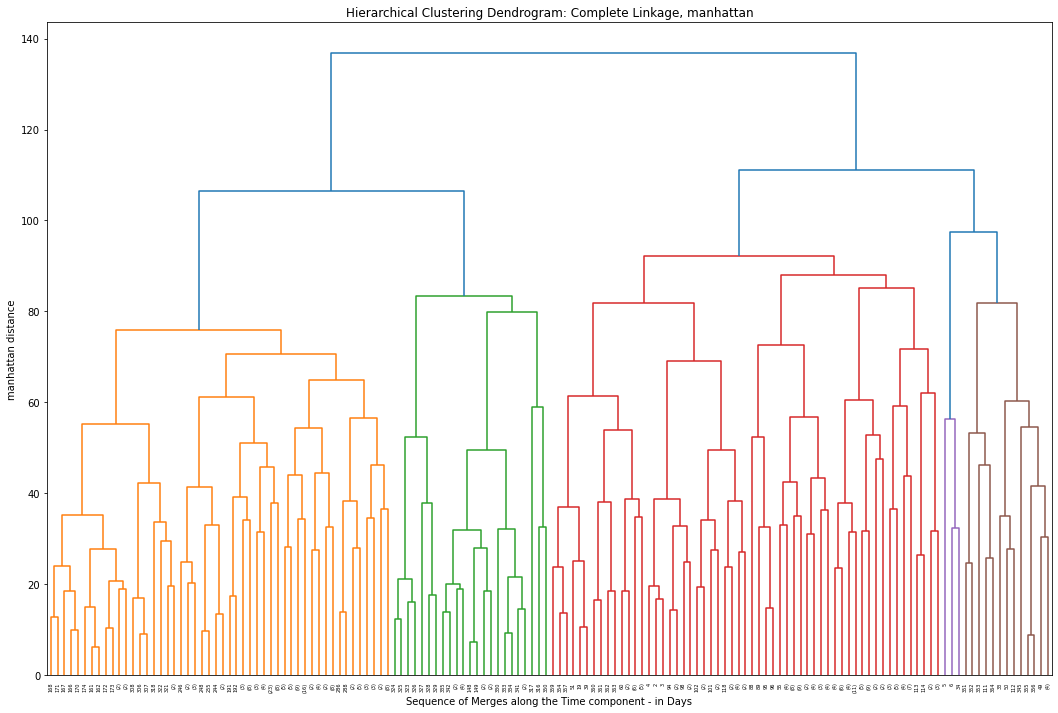

(             0          1      2          3     4     5     6  Cluster
 0    14.330000   5.610000  -5.20  12.190000 -0.83 -4.53  0.69        0
 1    14.960000  -1.520000  -2.36  18.389999  0.19 -4.07 -1.76        0
 2    15.530000  -8.950000   1.69  21.770000 -4.87 -2.27 -1.10        2
 3    16.389999 -10.860000   3.87  17.920000 -7.86 -1.18 -4.86        2
 4    16.730000  -6.240000   7.23  21.990000 -7.49 -5.32 -5.21        2
 ..         ...        ...    ...        ...   ...   ...   ...      ...
 360  10.060000 -20.980000  -2.60  -1.210000  4.15  2.41 -4.87        2
 361  10.800000 -25.950001  -5.39   2.160000  4.05  2.24 -0.61        2
 362  14.400000 -18.950001   8.91   2.610000  4.53  2.37  2.83        2
 363  16.299999 -20.410000  15.44   6.120000  5.51  2.67 -0.93        2
 364  16.660000 -14.680000  22.66  -0.070000  2.30  3.26  1.57        5
 
 [365 rows x 8 columns],
 array([0, 0, 2, 2, 2, 4, 4, 0, 6, 6, 6, 0, 6, 0, 0, 6, 0, 2, 0, 2, 0, 0,
        0, 0, 0, 0, 2, 2, 2, 0, 0, 

In [12]:
st_agglomerative(path2,data, var, 7, 7, p=7, affinity="euclidean", linkage="average", transformation=True, dim_reduction=True)